# Capstone Project - The Battle of Neighborhoods
#### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data acquisition and cleaning](#data)

##  Introduction:  Business Problem<a class="anchor" id="introduction"></a>
The coronavirus has infected people's lives since March 2020 and the Covid-19 cases are still increasing daily. In this project, I will try to find out if there are some kind of relationships between Covid-19 and Venues in New York City. For example, If there are more cases when more restaurants? If there are more cases when more coffee shops? <br>
This report will be targeted to stakeholders like the government to help people reduce their chances to get Covid-19 if people know the relationship between covid-19 and venues and avoid going to certain places. <br>
We will use our data science powers to analyze and visualize the data and then the result will be clearly displayed and expressed to the stakeholders.

## Data acquisition and preparation<a class="anchor" id="data"></a>
### Data needed
New York City is a large place, first of all, we need to divide New York City into neighborhoods and then get the venue data as well as Covid-19 data for each neighborhood so that we can compare the similarities and differences between those neighborhoods. 
Therefore, data we need:
* number of Covid-19 cases in the neighborhood
* number of venue in the neighborhood

### Data Sources
* Covid-19 data including total cases, borough, neighborhood, zipCode can be found <a href="https://www1.nyc.gov/site/doh/covid/covid-19-data.page">here</a>.
* New York City population data by zipcode which can be found <a href="https://www.newyork-demographics.com/zip_codes_by_population">here</a>
* New York City Zipcode list which can be found <a href="https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm">here</a>
* Venue data including type and location in every neighborhood/zipCode Area will be obtained using Foursquare API.
* New York data including neighborhood coordinates, borough can be found <a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json">here</a>
* Coordinates of neighbourhood/zipCode centers will be obtained using Google Maps geocoding

### Data Preparation
Before we get the data and start exploring it, we need to download all the dependencies that we will need.

In [1]:
import pandas as pd # library for data analsysis
import numpy as np 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import geopandas as gpd

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Let's scrape the NYC Zipcode from website

In [2]:
url = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
target = soup.find('table')
rows = target.find_all('tr')[1:]
nyc_zipcode = []
for row in rows:
    cols = row.find_all('td')
    zipcode = ''
    if len(cols) == 0:
        continue
    if len(cols) == 2:
        zipcodes = cols[1].text.strip()
    elif len(cols) == 3:
        zipcodes = cols[2].text.strip()
    nyc_zipcode += [x.strip() for x in zipcodes.split(',')]
len(nyc_zipcode)

178

#### Let's scrape the newyork demographics data from the website

In [3]:
url = 'https://www.newyork-demographics.com/zip_codes_by_population'
response = requests.get(url)
response

<Response [200]>

In [4]:
soup = BeautifulSoup(response.text, 'html.parser')
target_table = soup.find('table', {'class': 'ranklist'})

# get column titles for the table
column_titles = []
columns = target_table.find_all('th')
for title in columns:
    text = title.text
    column_titles.append(text)

data = []
# get column data we need
rows = target_table.find_all('tr')[1:]
for row in rows:
    cols = row.find_all('td')
    if len(cols) != 3:
        continue
    rank, zipcode, population = [x.text.strip() for x in cols]
    if 'and' in zipcode:
        continue
    population = population.replace(',', '')
    data.append([zipcode, population])

populationNYC_df = pd.DataFrame(np.array(data), columns=column_titles[1:])
populationNYC_df.rename(columns={'Zip Code':'ZIPCODE'}, inplace=True)
populationNYC_df.head()

ZIPCODE Population
0   11368     112425
1   11385     106717
2   10467     103732
3   11211     102624
4   11236     100331

In [5]:
# only keep rows in NYC
populationNYC_df = populationNYC_df[populationNYC_df['ZIPCODE'].isin(nyc_zipcode)]
populationNYC_df.head()

ZIPCODE Population
0   11368     112425
1   11385     106717
2   10467     103732
3   11211     102624
4   11236     100331

#### Let's get the Covid-19 data from the csv file using pandas library

In [6]:
covid_df = pd.read_csv('data_byzipcode.csv')
print('Data imported!')
covid_df.head()

Data imported!


ZIP                             Neighborhood    Borough  Cases  \
0  10001               Chelsea/NoMad/West Chelsea  Manhattan    485   
1  10002                Chinatown/Lower East Side  Manhattan   1486   
2  10003  East Village/Gramercy/Greenwich Village  Manhattan    740   
3  10004                       Financial District  Manhattan     60   
4  10005                       Financial District  Manhattan    121   

   Cases per 100,000  Deaths per 100,000  \
0            2058.31              118.83   
1            1936.02              208.45   
2            1375.42               65.05   
3            1643.56               27.39   
4            1441.14               23.82   

   Percent positive<br>(of people tested)  
0                                    4.56  
1                                    5.75  
2                                    2.72  
3                                    4.06  
4                                    3.61

In [7]:
# Check for missing data
missing_data = covid_df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

ZIP
False    177
Name: ZIP, dtype: int64

Neighborhood
False    177
Name: Neighborhood, dtype: int64

Borough
False    177
Name: Borough, dtype: int64

Cases
False    177
Name: Cases, dtype: int64

Cases per 100,000
False    177
Name: Cases per 100,000, dtype: int64

Deaths per 100,000
False    177
Name: Deaths per 100,000, dtype: int64

Percent positive<br>(of people tested)
False    177
Name: Percent positive<br>(of people tested), dtype: int64



In [8]:
# clean up the dataset to remove unnecessary columns
covid_df.drop(['Cases per 100,000', 'Deaths per 100,000', 'Percent positive<br>(of people tested)'], axis=1, inplace=True)
# rename the columns so that they make sense
covid_df.rename(columns={'ZIP':'ZIPCODE', 'Cases': 'Covid-Cases'}, inplace=True)
print('Data dimensions:', covid_df.shape)
covid_df.head()

Data dimensions: (177, 4)


ZIPCODE                             Neighborhood    Borough  Covid-Cases
0    10001               Chelsea/NoMad/West Chelsea  Manhattan          485
1    10002                Chinatown/Lower East Side  Manhattan         1486
2    10003  East Village/Gramercy/Greenwich Village  Manhattan          740
3    10004                       Financial District  Manhattan           60
4    10005                       Financial District  Manhattan          121

In [9]:
# add the population to the covid table
populationNYC_df['ZIPCODE'] = populationNYC_df['ZIPCODE'].astype(int)
covid_df = covid_df.merge(populationNYC_df, on=['ZIPCODE'], how='left')
covid_df.head()

ZIPCODE                             Neighborhood    Borough  Covid-Cases  \
0    10001               Chelsea/NoMad/West Chelsea  Manhattan          485   
1    10002                Chinatown/Lower East Side  Manhattan         1486   
2    10003  East Village/Gramercy/Greenwich Village  Manhattan          740   
3    10004                       Financial District  Manhattan           60   
4    10005                       Financial District  Manhattan          121   

  Population  
0      22924  
1      74993  
2      54682  
3       3028  
4       8831

In [10]:
covid_df.set_index('ZIPCODE', inplace=True)

In [11]:
# find missing population
covid_df[covid_df['Population'].isnull()]

Neighborhood    Borough  Covid-Cases  \
ZIPCODE                                                                
10069                         Lincoln Square  Manhattan           85   
10282                      Battery Park City  Manhattan           89   
10464                            City Island      Bronx          141   
10471    Fieldston/North Riverdale/Riverdale      Bronx          923   
11109                       Long Island City     Queens           75   

        Population  
ZIPCODE             
10069          NaN  
10282          NaN  
10464          NaN  
10471          NaN  
11109          NaN

In [12]:
# add missing population 
# data is from https://www.newyork-demographics.com/zip_codes_by_population
population_data = {10464: '4434', 10069: '5085', 10282: '5593', 10471: '21896', 11109: '5981'} 
for zipcode, population in population_data.items():
    covid_df.loc[zipcode, 'Population'] = population

In [13]:
covid_df = covid_df.reset_index()

In [14]:
covid_df['Population'] = covid_df['Population'].astype(int)
covid_df['Covid-Cases Percentage'] = covid_df['Covid-Cases']/covid_df['Population']
covid_df.head()

ZIPCODE                             Neighborhood    Borough  Covid-Cases  \
0    10001               Chelsea/NoMad/West Chelsea  Manhattan          485   
1    10002                Chinatown/Lower East Side  Manhattan         1486   
2    10003  East Village/Gramercy/Greenwich Village  Manhattan          740   
3    10004                       Financial District  Manhattan           60   
4    10005                       Financial District  Manhattan          121   

   Population  Covid-Cases Percentage  
0       22924                0.021157  
1       74993                0.019815  
2       54682                0.013533  
3        3028                0.019815  
4        8831                0.013702

#### Let's categorize the number of Covid-Cases into 'High', 'Midium', and 'Low'

In [15]:
bins = np.linspace(min(covid_df["Covid-Cases Percentage"]), max(covid_df["Covid-Cases Percentage"]), 4)
print(bins)
group_names = ['Low', 'Medium', 'High']
covid_df['CovidCases-binned'] = pd.cut(covid_df["Covid-Cases Percentage"], bins, labels=group_names, include_lowest=True)
covid_df.head(5)

[0.00767263 0.02316031 0.03864798 0.05413565]


ZIPCODE                             Neighborhood    Borough  Covid-Cases  \
0    10001               Chelsea/NoMad/West Chelsea  Manhattan          485   
1    10002                Chinatown/Lower East Side  Manhattan         1486   
2    10003  East Village/Gramercy/Greenwich Village  Manhattan          740   
3    10004                       Financial District  Manhattan           60   
4    10005                       Financial District  Manhattan          121   

   Population  Covid-Cases Percentage CovidCases-binned  
0       22924                0.021157               Low  
1       74993                0.019815               Low  
2       54682                0.013533               Low  
3        3028                0.019815               Low  
4        8831                0.013702               Low

In [16]:
covid_df["CovidCases-binned"].value_counts()

Medium    94
Low       55
High      28
Name: CovidCases-binned, dtype: int64

Text(0.5, 1.0, 'Covid-Cases bins')

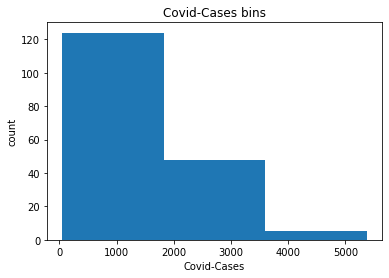

In [17]:
# draw historgram of attribute "Covid-Cases" with bins = 3
plt.hist(covid_df["Covid-Cases"], bins = 3)

plt.xlabel("Covid-Cases")
plt.ylabel("count")
plt.title("Covid-Cases bins")

#### Let's get dataframe by covid cases categories with latitudes and longitudes

In [18]:
def getDataFrameByCategory(category):
    df = covid_df[covid_df['CovidCases-binned'] == category].reset_index(drop=True)
    return df

In [19]:
# get latitude and longitude for zipcodes
def addCoordinateToDataFrame(df):
    zipcodes = list(df['ZIPCODE'].map(int))
    geolocator = Nominatim(user_agent='nyc_zipcode_explorer')

    latitudes, longitudes = [], []

    for zipcode in zipcodes:
        location = geolocator.geocode({"postalcode": zipcode, "country": "USA"})
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
        
    df['Latitude'] = np.array(latitudes)
    df['Longitude'] = np.array(longitudes)

In [20]:
# create map of New York using latitude and longitude values
def createMap(df):
    map_newyork = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=10)
    colors = {'High': 'red', 'Medium': 'blue', 'Low': 'lightgreen'}
    
    # add markers to map
    for lat, lng, borough, neighborhood, cases, level in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood'], df['Covid-Cases'], df['CovidCases-binned']):
        label = '{}, {}, {}'.format(neighborhood, borough, cases)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=colors[level],
            fill=True,
            fill_color=colors[level],
            fill_opacity=1,
            parse_html=False).add_to(map_newyork)  
    return map_newyork

#### Let's get all the high covid cases areas

In [21]:
hcovid_df = getDataFrameByCategory('High')
addCoordinateToDataFrame(hcovid_df)
hcovid_df.head()

ZIPCODE                              Neighborhood        Borough  \
0    10301                    Silver Lake/St. George  Staten Island   
1    10302                                  Elm Park  Staten Island   
2    10303  Graniteville/Mariner's Harbor/Port Ivory  Staten Island   
3    10304                        New Dorp/Todt Hill  Staten Island   
4    10451                         Concourse/Melrose          Bronx   

   Covid-Cases  Population  Covid-Cases Percentage CovidCases-binned  \
0         1497       38733                0.038649              High   
1          762       18204                0.041859              High   
2         1030       25947                0.039696              High   
3         1704       41064                0.041496              High   
4         1901       47798                0.039772              High   

    Latitude  Longitude  
0  40.629516 -74.093853  
1  40.630756 -74.137176  
2  40.630273 -74.158773  
3  40.609770 -74.088140  
4  40.820494 -73.919919

In [22]:
hcovid_df.shape

(28, 9)

In [23]:
mcovid_df = getDataFrameByCategory('Medium')
addCoordinateToDataFrame(mcovid_df)
mcovid_df.head()

ZIPCODE                                       Neighborhood    Borough  \
0    10018                   Hell's Kitchen/Midtown Manhattan  Manhattan   
1    10029                                        East Harlem  Manhattan   
2    10031                       Hamilton Heights/West Harlem  Manhattan   
3    10032                         Washington Heights (South)  Manhattan   
4    10033  Washington Heights (North)/Washington Heights ...  Manhattan   

   Covid-Cases  Population  Covid-Cases Percentage CovidCases-binned  \
0          232        9687                0.023950            Medium   
1         2248       79597                0.028242            Medium   
2         1736       60254                0.028811            Medium   
3         1953       64264                0.030390            Medium   
4         1720       59607                0.028856            Medium   

    Latitude  Longitude  
0  40.754015 -73.990399  
1  40.792047 -73.944446  
2  40.825313 -73.948358  
3  40.837385 -73.941017  
4  40.849321 -73.935208

In [24]:
mcovid_df.shape

(94, 9)

In [25]:
lcovid_df = getDataFrameByCategory('Low')
addCoordinateToDataFrame(lcovid_df)
lcovid_df.head()

ZIPCODE                             Neighborhood    Borough  Covid-Cases  \
0    10001               Chelsea/NoMad/West Chelsea  Manhattan          485   
1    10002                Chinatown/Lower East Side  Manhattan         1486   
2    10003  East Village/Gramercy/Greenwich Village  Manhattan          740   
3    10004                       Financial District  Manhattan           60   
4    10005                       Financial District  Manhattan          121   

   Population  Covid-Cases Percentage CovidCases-binned   Latitude  Longitude  
0       22924                0.021157               Low  40.748416 -73.994107  
1       74993                0.019815               Low  40.717055 -73.989320  
2       54682                0.013533               Low  40.731579 -73.988529  
3        3028                0.019815               Low  40.700769 -74.013464  
4        8831                0.013702               Low  40.720503 -74.006704

In [26]:
lcovid_df.shape

(55, 9)

In [27]:
df = pd.concat([hcovid_df, mcovid_df, lcovid_df], ignore_index=True)
covid_map = createMap(df)
covid_map

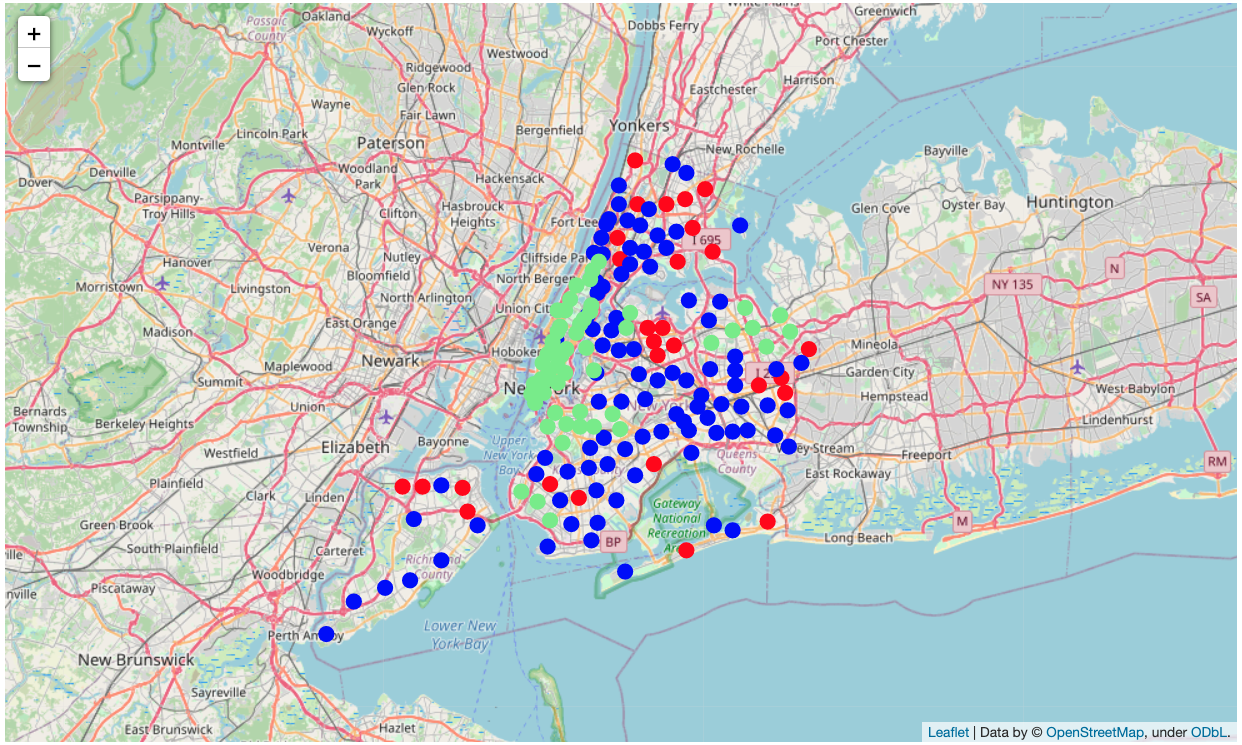

In [28]:
# In case you cannot see the map
from IPython.display import Image
Image(filename='covid_map_nyc.png') 

#### Define Foursquare Credentials and Version

In [29]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Get Nearby Venues

In [30]:
def getNearbyVenues(zipcodes, names, boroughs, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, name, borough, lat, lng in zip(zipcodes, names, boroughs, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode,
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIPCODE', 
                             'Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

#### Get Nearby Venues for HIGH Covid Area

In [31]:
hcovid_venues = getNearbyVenues(zipcodes=hcovid_df['ZIPCODE'], names=hcovid_df['Neighborhood'], boroughs=hcovid_df['Borough'], latitudes=hcovid_df['Latitude'], longitudes=hcovid_df['Longitude'])
hcovid_venues.head()

ZIPCODE            Neighborhood        Borough  Neighborhood Latitude  \
0    10301  Silver Lake/St. George  Staten Island              40.629516   
1    10301  Silver Lake/St. George  Staten Island              40.629516   
2    10301  Silver Lake/St. George  Staten Island              40.629516   
3    10301  Silver Lake/St. George  Staten Island              40.629516   
4    10301  Silver Lake/St. George  Staten Island              40.629516   

   Neighborhood Longitude                                           Venue  \
0              -74.093853                                Silver Lake Park   
1              -74.093853                        Silver Lake Park Dog Run   
2              -74.093853  MTA Bus - Castleton Av & Haven Esplanade (S46)   
3              -74.093853                                  Casa Belvedere   
4              -74.093853     MTA Bus - Castleton Av & Woodstock Av (S46)   

   Venue Latitude  Venue Longitude Venue Category  
0       40.628057       -74.094973           Park  
1       40.626393       -74.091626        Dog Run  
2       40.633284       -74.092001       Bus Stop  
3       40.628701       -74.088393  Historic Site  
4       40.632690       -74.090129       Bus Stop

In [32]:
hcovid_venues.groupby(['ZIPCODE', 'Neighborhood', 'Borough']).count()['Venue'].head()

ZIPCODE  Neighborhood                              Borough      
10301    Silver Lake/St. George                    Staten Island     7
10302    Elm Park                                  Staten Island    16
10303    Graniteville/Mariner's Harbor/Port Ivory  Staten Island    13
10304    New Dorp/Todt Hill                        Staten Island    13
10451    Concourse/Melrose                         Bronx            20
Name: Venue, dtype: int64

In [33]:
print('There are {} uniques categories.'.format(len(hcovid_venues['Venue Category'].unique())))

There are 148 uniques categories.


#### Get Nearby Venues for MEDIUM Covid Area

In [34]:
mcovid_venues = getNearbyVenues(zipcodes=mcovid_df['ZIPCODE'], names=mcovid_df['Neighborhood'], boroughs=mcovid_df['Borough'], latitudes=mcovid_df['Latitude'], longitudes=mcovid_df['Longitude'])
mcovid_venues.head()

ZIPCODE                      Neighborhood    Borough  \
0    10018  Hell's Kitchen/Midtown Manhattan  Manhattan   
1    10018  Hell's Kitchen/Midtown Manhattan  Manhattan   
2    10018  Hell's Kitchen/Midtown Manhattan  Manhattan   
3    10018  Hell's Kitchen/Midtown Manhattan  Manhattan   
4    10018  Hell's Kitchen/Midtown Manhattan  Manhattan   

   Neighborhood Latitude  Neighborhood Longitude                  Venue  \
0              40.754015              -73.990399               Boqueria   
1              40.754015              -73.990399               Studio L   
2              40.754015              -73.990399         Midtown Comics   
3              40.754015              -73.990399  Hampton Inn by Hilton   
4              40.754015              -73.990399    Best Bagel & Coffee   

   Venue Latitude  Venue Longitude    Venue Category  
0       40.755582       -73.990337  Tapas Restaurant  
1       40.754202       -73.990393        Nail Salon  
2       40.754819       -73.987970        Comic Shop  
3       40.755607       -73.988663             Hotel  
4       40.752168       -73.991066        Bagel Shop

In [35]:
mcovid_venues.groupby(['ZIPCODE', 'Neighborhood', 'Borough']).count()['Venue'].head()

ZIPCODE  Neighborhood                                           Borough  
10018    Hell's Kitchen/Midtown Manhattan                       Manhattan    100
10029    East Harlem                                            Manhattan     44
10031    Hamilton Heights/West Harlem                           Manhattan     77
10032    Washington Heights (South)                             Manhattan     56
10033    Washington Heights (North)/Washington Heights (South)  Manhattan     96
Name: Venue, dtype: int64

In [36]:
print('There are {} uniques categories.'.format(len(mcovid_venues['Venue Category'].unique())))

There are 280 uniques categories.


#### Get Nearby Venues For Low Covid Area

In [37]:
lcovid_venues = getNearbyVenues(zipcodes=lcovid_df['ZIPCODE'], names=lcovid_df['Neighborhood'], boroughs=lcovid_df['Borough'], latitudes=lcovid_df['Latitude'], longitudes=lcovid_df['Longitude'])
lcovid_venues.head()

ZIPCODE                Neighborhood    Borough  Neighborhood Latitude  \
0    10001  Chelsea/NoMad/West Chelsea  Manhattan              40.748416   
1    10001  Chelsea/NoMad/West Chelsea  Manhattan              40.748416   
2    10001  Chelsea/NoMad/West Chelsea  Manhattan              40.748416   
3    10001  Chelsea/NoMad/West Chelsea  Manhattan              40.748416   
4    10001  Chelsea/NoMad/West Chelsea  Manhattan              40.748416   

   Neighborhood Longitude                      Venue  Venue Latitude  \
0              -73.994107     New York Pizza Suprema       40.750124   
1              -73.994107        ALT: A Little Taste       40.746854   
2              -73.994107   Martinez Handmade Cigars       40.747769   
3              -73.994107       Renzo Gracie Academy       40.748975   
4              -73.994107  The National Opera Center       40.747644   

   Venue Longitude         Venue Category  
0       -73.994992            Pizza Place  
1       -73.992449                   Café  
2       -73.992685             Smoke Shop  
3       -73.993678             Boxing Gym  
4       -73.993106  Performing Arts Venue

In [38]:
lcovid_venues.groupby(['ZIPCODE', 'Neighborhood', 'Borough']).count()['Venue'].head()

ZIPCODE  Neighborhood                             Borough  
10001    Chelsea/NoMad/West Chelsea               Manhattan    100
10002    Chinatown/Lower East Side                Manhattan    100
10003    East Village/Gramercy/Greenwich Village  Manhattan    100
10004    Financial District                       Manhattan     41
10005    Financial District                       Manhattan    100
Name: Venue, dtype: int64

In [39]:
print('There are {} uniques categories.'.format(len(lcovid_venues['Venue Category'].unique())))

There are 327 uniques categories.


#### Let's create functions to get the most common Venues

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
def generateMostCommonVenuesDataFrame(df, num_top_venues):
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['ZIPCODE', 'Neighborhood', 'Borough']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{}'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['ZIPCODE'] = df['ZIPCODE']
    neighborhoods_venues_sorted['Neighborhood'] = df['Neighborhood']
    neighborhoods_venues_sorted['Borough'] = df['Borough']

    for ind in np.arange(df.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 3:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted

#### Analyze Each Neighborhood in High Covid Area

In [42]:
# one hot encoding
hcovid_onehot = pd.get_dummies(hcovid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hcovid_onehot['ZIPCODE'] = hcovid_venues['ZIPCODE'] 
hcovid_onehot['Neighborhood'] = hcovid_venues['Neighborhood'] 
hcovid_onehot['Borough'] = hcovid_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = list(hcovid_onehot.columns[-3:]) + list(hcovid_onehot.columns[:-3])
hcovid_onehot = hcovid_onehot[fixed_columns]

hcovid_onehot.head()

ZIPCODE            Neighborhood        Borough  American Restaurant  \
0    10301  Silver Lake/St. George  Staten Island                    0   
1    10301  Silver Lake/St. George  Staten Island                    0   
2    10301  Silver Lake/St. George  Staten Island                    0   
3    10301  Silver Lake/St. George  Staten Island                    0   
4    10301  Silver Lake/St. George  Staten Island                    0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0                 0                       0            0                    0   
1                 0                       0            0                    0   
2                 0                       0            0                    0   
3                 0                       0            0                    0   
4                 0                       0            0                    0   

   Asian Restaurant  Automotive Shop  Bagel Shop  Bakery  Bank  Bar  \
0                 0                0           0       0     0    0   
1                 0                0           0       0     0    0   
2                 0                0           0       0     0    0   
3                 0                0           0       0     0    0   
4                 0                0           0       0     0    0   

   Baseball Field  Basketball Court  Beach  Bistro  Boutique  Breakfast Spot  \
0               0                 0      0       0         0               0   
1               0                 0      0       0         0               0   
2               0                 0      0       0         0               0   
3               0                 0      0       0         0               0   
4               0                 0      0       0         0               0   

   Bubble Tea Shop  Buffet  Burger Joint  Bus Line  Bus Station  Bus Stop  \
0                0       0             0         0            0         0   
1                0       0             0         0            0         0   
2                0       0             0         0            0         1   
3                0       0             0         0            0         0   
4                0       0             0         0            0         1   

   Business Service  Butcher  Café  Cajun / Creole Restaurant  Candy Store  \
0                 0        0     0                          0            0   
1                 0        0     0                          0            0   
2                 0        0     0                          0            0   
3                 0        0     0                          0            0   
4                 0        0     0                          0            0   

   Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Clothing Store  \
0                     0            0                   0               0   
1                     0            0                   0               0   
2                     0            0                   0               0   
3                     0            0                   0               0   
4                     0            0                   0               0   

   Coffee Shop  Colombian Restaurant  Construction & Landscaping  \
0            0                     0                           0   
1            0                     0                           0   
2            0                     0                           0   
3            0                     0                           0   
4            0                     0                           0   

   Convenience Store  Cosmetics Shop  Dance Studio  Deli / Bodega  \
0                  0               0             0              0   
1                  0               0             0              0   
2                  0               0             0              0   
3                  0               0             0              0   
4                  0

In [43]:
hcovid_onehot.shape

(679, 151)

In [44]:
hcovid_grouped = hcovid_onehot.groupby(['ZIPCODE', 'Neighborhood', 'Borough']).mean().reset_index()
hcovid_grouped.head()

ZIPCODE                              Neighborhood        Borough  \
0    10301                    Silver Lake/St. George  Staten Island   
1    10302                                  Elm Park  Staten Island   
2    10303  Graniteville/Mariner's Harbor/Port Ivory  Staten Island   
3    10304                        New Dorp/Todt Hill  Staten Island   
4    10451                         Concourse/Melrose          Bronx   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0                  0.0               0.0                     0.0         0.00   
1                  0.0               0.0                     0.0         0.00   
2                  0.0               0.0                     0.0         0.00   
3                  0.0               0.0                     0.0         0.00   
4                  0.0               0.0                     0.0         0.05   

   Arts & Crafts Store  Asian Restaurant  Automotive Shop  Bagel Shop  Bakery  \
0                  0.0               0.0         0.000000    0.000000   0.000   
1                  0.0               0.0         0.000000    0.000000   0.125   
2                  0.0               0.0         0.000000    0.000000   0.000   
3                  0.0               0.0         0.076923    0.076923   0.000   
4                  0.0               0.0         0.000000    0.000000   0.000   

   Bank       Bar  Baseball Field  Basketball Court  Beach  Bistro  Boutique  \
0   0.0  0.000000             0.0               0.0    0.0     0.0       0.0   
1   0.0  0.000000             0.0               0.0    0.0     0.0       0.0   
2   0.0  0.076923             0.0               0.0    0.0     0.0       0.0   
3   0.0  0.000000             0.0               0.0    0.0     0.0       0.0   
4   0.0  0.000000             0.0               0.0    0.0     0.0       0.0   

   Breakfast Spot  Bubble Tea Shop  Buffet  Burger Joint  Bus Line  \
0          0.0000              0.0     0.0           0.0       0.0   
1          0.0625              0.0     0.0           0.0       0.0   
2          0.0000              0.0     0.0           0.0       0.0   
3          0.0000              0.0     0.0           0.0       0.0   
4          0.0000              0.0     0.0           0.0       0.0   

   Bus Station  Bus Stop  Business Service  Butcher  Café  \
0          0.0  0.428571               0.0      0.0   0.0   
1          0.0  0.062500               0.0      0.0   0.0   
2          0.0  0.153846               0.0      0.0   0.0   
3          0.0  0.153846               0.0      0.0   0.0   
4          0.0  0.000000               0.0      0.0   0.0   

   Cajun / Creole Restaurant  Candy Store  Caribbean Restaurant  Cheese Shop  \
0                        0.0          0.0                   0.0          0.0   
1                        0.0          0.0                   0.0          0.0   
2                        0.0          0.0                   0.0          0.0   
3                        0.0          0.0                   0.0          0.0   
4                        0.0          0.0                   0.0          0.0   

   Chinese Restaurant  Clothing Store  Coffee Shop  Colombian Restaurant  \
0            0.000000             0.0          0.0                   0.0   
1            0.062500             0.0          0.0                   0.0   
2            0.076923             0.0          0.0                   0.0   
3            0.000000             0.0          0.0                   0.0   
4            0.050000             0.0          0.0                   0.0   

   Construction & Landscaping  Convenience Store  Cosmetics Shop  \
0                         0.0           0.000000          0.0000   
1                         0.0           0.000000          0.0625   
2                         0.0           0.076923          0.0000   
3                         0.0           0.076923          0.0000   
4                         0.0           0.000000       

In [45]:
hcovid_grouped.shape

(28, 151)

In [46]:
high_covid_venues_sorted = generateMostCommonVenuesDataFrame(hcovid_grouped, 10)
high_covid_venues_sorted.head()

ZIPCODE                              Neighborhood        Borough  \
0    10301                    Silver Lake/St. George  Staten Island   
1    10302                                  Elm Park  Staten Island   
2    10303  Graniteville/Mariner's Harbor/Port Ivory  Staten Island   
3    10304                        New Dorp/Todt Hill  Staten Island   
4    10451                         Concourse/Melrose          Bronx   

              1st              2nd                 3rd                   4th  \
0        Bus Stop          Dog Run       Historic Site  Gym / Fitness Center   
1     Pizza Place           Bakery      Ice Cream Shop   Fried Chicken Joint   
2        Bus Stop    Deli / Bodega  Chinese Restaurant    Spanish Restaurant   
3   Deli / Bodega         Bus Stop         Pizza Place                  Park   
4  Ice Cream Shop  Supplement Shop  Mexican Restaurant              Pharmacy   

                 5th                6th                  7th  \
0               Park        Dry Cleaner  Filipino Restaurant   
1     Cosmetics Shop          Pool Hall   Chinese Restaurant   
2         Sports Bar                Bar          Supermarket   
3  Indian Restaurant  Convenience Store      Automotive Shop   
4        Pizza Place      Shopping Mall   Mac & Cheese Joint   

                    8th             9th                 10th  
0  Fast Food Restaurant  Farmers Market          Event Space  
1    Mexican Restaurant        Bus Stop  Martial Arts School  
2              Pharmacy  Hardware Store    Convenience Store  
3            Bagel Shop      Food Truck   Spanish Restaurant  
4                   Gym           Diner          Art Gallery

#### Analyze Each Neighborhood in MEDIUM Covid Area

In [47]:
# one hot encoding
mcovid_onehot = pd.get_dummies(mcovid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mcovid_onehot['ZIPCODE'] = mcovid_venues['ZIPCODE'] 
mcovid_onehot['Neighborhood'] = mcovid_venues['Neighborhood'] 
mcovid_onehot['Borough'] = mcovid_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = list(mcovid_onehot.columns[-3:]) + list(mcovid_onehot.columns[:-3])
mcovid_onehot = mcovid_onehot[fixed_columns]

mcovid_onehot.head()

ZIPCODE                      Neighborhood    Borough  Accessories Store  \
0    10018  Hell's Kitchen/Midtown Manhattan  Manhattan                  0   
1    10018  Hell's Kitchen/Midtown Manhattan  Manhattan                  0   
2    10018  Hell's Kitchen/Midtown Manhattan  Manhattan                  0   
3    10018  Hell's Kitchen/Midtown Manhattan  Manhattan                  0   
4    10018  Hell's Kitchen/Midtown Manhattan  Manhattan                  0   

   Afghan Restaurant  African Restaurant  Airport Lounge  Airport Tram  \
0                  0                   0               0             0   
1                  0                   0               0             0   
2                  0                   0               0             0   
3                  0                   0               0             0   
4                  0                   0               0             0   

   American Restaurant  Amphitheater  Arepa Restaurant  Art Gallery  \
0                    0             0                 0            0   
1                    0             0                 0            0   
2                    0             0                 0            0   
3                    0             0                 0            0   
4                    0             0                 0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       0     0    0               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           1       0     0    0               0   

   Basketball Court  Basketball Stadium  Beer Bar  Beer Garden  Beer Store  \
0                 0                   0         0            0           0   
1                 0                   0         0            0           0   
2                 0                   0         0            0           0   
3                 0                   0         0            0           0   
4                 0                   0         0            0           0   

   Big Box Store  Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  \
0              0           0       0           0              0          0   
1              0           0       0           0              0          0   
2              0           0       0           0              0          0   
3              0           0       0           0              0          0   
4              0           0       0           0              0          0   

   Boutique  Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  \
0         0              0           0                     0               0   
1         0              0           0                     0               0   
2         0              0           0                     0               0   
3         0              0           0                     0               0   
4         0              0           0                     0               0   

   Brewery  Bubble Tea Shop  Buffet  Burger Joint  Burrito Place  Bus Line  \
0        0                0       0             0              0         0   
1        0                0       0             0              0         0   
2        0                0       0             0              0       

In [48]:
mcovid_onehot.shape

(2892, 283)

In [49]:
mcovid_grouped = mcovid_onehot.groupby(['ZIPCODE', 'Neighborhood', 'Borough']).mean().reset_index()
mcovid_grouped.head()

ZIPCODE                                       Neighborhood    Borough  \
0    10018                   Hell's Kitchen/Midtown Manhattan  Manhattan   
1    10029                                        East Harlem  Manhattan   
2    10031                       Hamilton Heights/West Harlem  Manhattan   
3    10032                         Washington Heights (South)  Manhattan   
4    10033  Washington Heights (North)/Washington Heights ...  Manhattan   

   Accessories Store  Afghan Restaurant  African Restaurant  Airport Lounge  \
0           0.000000                0.0                 0.0             0.0   
1           0.000000                0.0                 0.0             0.0   
2           0.000000                0.0                 0.0             0.0   
3           0.000000                0.0                 0.0             0.0   
4           0.010417                0.0                 0.0             0.0   

   Airport Tram  American Restaurant  Amphitheater  Arepa Restaurant  \
0           0.0             0.020000           0.0          0.000000   
1           0.0             0.000000           0.0          0.000000   
2           0.0             0.012987           0.0          0.012987   
3           0.0             0.035714           0.0          0.000000   
4           0.0             0.000000           0.0          0.010417   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0     0.010000         0.0                 0.01          0.000000   
1     0.000000         0.0                 0.00          0.000000   
2     0.012987         0.0                 0.00          0.000000   
3     0.000000         0.0                 0.00          0.000000   
4     0.000000         0.0                 0.00          0.020833   

   Athletics & Sports  Automotive Shop  BBQ Joint  Bagel Shop    Bakery  \
0                 0.0              0.0   0.010000    0.010000  0.020000   
1                 0.0              0.0   0.000000    0.000000  0.068182   
2                 0.0              0.0   0.000000    0.000000  0.025974   
3                 0.0              0.0   0.017857    0.017857  0.053571   
4                 0.0              0.0   0.000000    0.000000  0.062500   

       Bank       Bar  Baseball Field  Basketball Court  Basketball Stadium  \
0  0.000000  0.000000             0.0               0.0                0.01   
1  0.000000  0.000000             0.0               0.0                0.00   
2  0.012987  0.051948             0.0               0.0                0.00   
3  0.035714  0.035714             0.0               0.0                0.00   
4  0.020833  0.000000             0.0               0.0                0.00   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Trail  Bistro  \
0  0.000000          0.0         0.0            0.0         0.0     0.0   
1  0.022727          0.0         0.0            0.0         0.0     0.0   
2  0.012987          0.0         0.0            0.0         0.0     0.0   
3  0.000000          0.0         0.0            0.0         0.0     0.0   
4  0.010417          0.0         0.0            0.0         0.0     0.0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0         0.0            0.0   0.010000      0.01            0.0         0.0   
1         0.0            0.0   0.000000      0.00            0.0         0.0   
2         0.0            0.0   0.000000      0.00            0.0         0.0   
3         0.0            0.0   0.035714      0.00            0.0         0.0   
4         0.0            0.0   0.000000      0.00            0.0         0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bubble Tea Shop  Buffet  \
0                   0.0        0.000000      0.0             0.01     0.0   
1                   0.0        0.000000      0.0             0.00     0.0   
2                   0.0        0.000000      0.0             0.00     0.0   
3                   0.0        0.000000      0.0         

In [50]:
medium_covid_venues_sorted = generateMostCommonVenuesDataFrame(mcovid_grouped, 10)
medium_covid_venues_sorted.head()

ZIPCODE                                       Neighborhood    Borough  \
0    10018                   Hell's Kitchen/Midtown Manhattan  Manhattan   
1    10029                                        East Harlem  Manhattan   
2    10031                       Hamilton Heights/West Harlem  Manhattan   
3    10032                         Washington Heights (South)  Manhattan   
4    10033  Washington Heights (North)/Washington Heights ...  Manhattan   

                  1st              2nd                 3rd  \
0               Hotel     Burger Joint         Coffee Shop   
1  Mexican Restaurant  Thai Restaurant              Bakery   
2         Pizza Place             Café                 Bar   
3         Coffee Shop      Pizza Place  Mexican Restaurant   
4              Bakery    Grocery Store                Café   

                  4th                5th                        6th  \
0             Theater        Music Venue         Italian Restaurant   
1      Sandwich Place         Restaurant  Latin American Restaurant   
2  Chinese Restaurant        Coffee Shop                Yoga Studio   
3              Bakery         Donut Shop            Thai Restaurant   
4  Spanish Restaurant  Mobile Phone Shop                Pizza Place   

                         7th                      8th                   9th  \
0                 Steakhouse              Music Store        Clothing Store   
1                   Pharmacy  New American Restaurant              Beer Bar   
2         Mexican Restaurant            Deli / Bodega  Caribbean Restaurant   
3                  Bookstore                      Bar                  Bank   
4  Latin American Restaurant                     Park    Chinese Restaurant   

                        10th  
0                Yoga Studio  
1                Gas Station  
2                     Bakery  
3  Latin American Restaurant  
4                     Lounge

#### Analyze Each Neighborhood in Low Covid Area

In [51]:
# one hot encoding
lcovid_onehot = pd.get_dummies(lcovid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lcovid_onehot['ZIPCODE'] = lcovid_venues['ZIPCODE'] 
lcovid_onehot['Neighborhood'] = lcovid_venues['Neighborhood'] 
lcovid_onehot['Borough'] = lcovid_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = list(lcovid_onehot.columns[-3:]) + list(lcovid_onehot.columns[:-3])
lcovid_onehot = lcovid_onehot[fixed_columns]

lcovid_onehot.head()

ZIPCODE                Neighborhood    Borough  Accessories Store  \
0    10001  Chelsea/NoMad/West Chelsea  Manhattan                  0   
1    10001  Chelsea/NoMad/West Chelsea  Manhattan                  0   
2    10001  Chelsea/NoMad/West Chelsea  Manhattan                  0   
3    10001  Chelsea/NoMad/West Chelsea  Manhattan                  0   
4    10001  Chelsea/NoMad/West Chelsea  Manhattan                  0   

   African Restaurant  American Restaurant  Arepa Restaurant  \
0                   0                    0                 0   
1                   0                    0                 0   
2                   0                    0                 0   
3                   0                    0                 0   
4                   0                    0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0                 0                   0           0                      0   
1                 0                   0           0                      0   
2                 0                   0           0                      0   
3                 0                   0           0                      0   
4                 0                   0           0                      0   

   Austrian Restaurant  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                    0                0          0           0           0   
1                    0                0          0           0           0   
2                    0                0          0           0           0   
3                    0                0          0           0           0   
4                    0                0          0           0           0   

   Baggage Locker  Bakery  Bank  Bar  Basketball Court  Basketball Stadium  \
0               0       0     0    0                 0                   0   
1               0       0     0    0                 0                   0   
2               0       0     0    0                 0                   0   
3               0       0     0    0                 0                   0   
4               0       0     0    0                 0                   0   

   Beer Bar  Beer Garden  Beer Store  Bike Rental / Bike Share  Bike Shop  \
0         0            0           0                         0          0   
1         0            0           0                         0          0   
2         0            0           0                         0          0   
3         0            0           0                         0          0   
4         0            0           0                         0          0   

   Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0           0       0           0              0          0         0   
1           0       0           0              0          0         0   
2           0       0           0              0          0         0   
3           0       0           0              0          0         0   
4           0       0           0              0          0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        0   
1              0           0                     0               0        0   
2              0           0                     0               0        0   
3              0           1                     0               0        0   
4              0           0  

In [52]:
lcovid_onehot.shape

(4229, 330)

In [53]:
lcovid_grouped = lcovid_onehot.groupby(['ZIPCODE', 'Neighborhood', 'Borough']).mean().reset_index()
lcovid_grouped.head()

ZIPCODE                             Neighborhood    Borough  \
0    10001               Chelsea/NoMad/West Chelsea  Manhattan   
1    10002                Chinatown/Lower East Side  Manhattan   
2    10003  East Village/Gramercy/Greenwich Village  Manhattan   
3    10004                       Financial District  Manhattan   
4    10005                       Financial District  Manhattan   

   Accessories Store  African Restaurant  American Restaurant  \
0                0.0                 0.0              0.03000   
1                0.0                 0.0              0.03000   
2                0.0                 0.0              0.01000   
3                0.0                 0.0              0.04878   
4                0.0                 0.0              0.04000   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0               0.0                     0.0         0.00        0.00   
1               0.0                     0.0         0.00        0.00   
2               0.0                     0.0         0.00        0.00   
3               0.0                     0.0         0.00        0.00   
4               0.0                     0.0         0.04        0.01   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                 0.01              0.00                 0.0         0.0   
1                 0.00              0.02                 0.0         0.0   
2                 0.01              0.01                 0.0         0.0   
3                 0.00              0.00                 0.0         0.0   
4                 0.00              0.02                 0.0         0.0   

   Australian Restaurant  Austrian Restaurant  Automotive Shop  BBQ Joint  \
0                   0.00                 0.00              0.0       0.00   
1                   0.02                 0.01              0.0       0.00   
2                   0.01                 0.00              0.0       0.01   
3                   0.00                 0.00              0.0       0.00   
4                   0.01                 0.00              0.0       0.00   

   Baby Store  Bagel Shop  Baggage Locker  Bakery  Bank       Bar  \
0        0.01        0.02             0.0    0.02   0.0  0.040000   
1        0.00        0.01             0.0    0.02   0.0  0.050000   
2        0.00        0.02             0.0    0.01   0.0  0.010000   
3        0.00        0.00             0.0    0.00   0.0  0.097561   
4        0.00        0.00             0.0    0.03   0.0  0.010000   

   Basketball Court  Basketball Stadium  Beer Bar  Beer Garden  Beer Store  \
0               0.0                0.01      0.00          0.0         0.0   
1               0.0                0.00      0.01          0.0         0.0   
2               0.0                0.00      0.00          0.0         0.0   
3               0.0                0.00      0.00          0.0         0.0   
4               0.0                0.00      0.00          0.0         0.0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                       0.0        0.0         0.0     0.0         0.0   
1                       0.0        0.0         0.0     0.0         0.0   
2                       0.0        0.0         0.0     0.0         0.0   
3                       0.0        0.0         0.0     0.0         0.0   
4                       0.0        0.0         0.0     0.0         0.0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0       0.000000       0.00      0.00            0.0        0.02   
1       0.000000       0.00      0.02            0.0        0.00   
2       0.000000       0.01      0.00            0.0        0.00   
3       0.097561       0.00      0.00            0.0        0.00   
4       0.000000       0.00      0.04            0.0        0.01   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0             0.0      0.0          0

In [54]:
low_covid_venues_sorted = generateMostCommonVenuesDataFrame(lcovid_grouped, 5)
low_covid_venues_sorted.head()

ZIPCODE                             Neighborhood    Borough  \
0    10001               Chelsea/NoMad/West Chelsea  Manhattan   
1    10002                Chinatown/Lower East Side  Manhattan   
2    10003  East Village/Gramercy/Greenwich Village  Manhattan   
3    10004                       Financial District  Manhattan   
4    10005                       Financial District  Manhattan   

                  1st                   2nd                  3rd  \
0               Hotel  Gym / Fitness Center          Coffee Shop   
1  Mexican Restaurant                   Bar       Sandwich Place   
2        Dessert Shop           Coffee Shop          Pizza Place   
3  Mexican Restaurant         Boat or Ferry                  Bar   
4        Cocktail Bar     French Restaurant  American Restaurant   

                   4th             5th  
0                  Bar     Salad Place  
1          Coffee Shop            Café  
2  Japanese Restaurant  Ice Cream Shop  
3         Cocktail Bar        Heliport  
4   Italian Restaurant     Art Gallery

#### Summarize High, Medium, Low Area Venues

In [55]:
# Create functions to generate new Dataframe
import collections

def getVenesFreqDataFrame(df):
    h_list = []

    index = list(df.columns[3:])
    for i in index:
        h_list += list(df[i])

    h_list = ['Restaurant' if 'Restaurant' in venue else venue for venue in h_list]
    h_counter = collections.Counter(h_list)

    venues = list(h_counter.keys())
    freq = list(h_counter.values())

    new_df = pd.DataFrame(columns=['Venue', 'Freq'])
    new_df['Venue'] = np.array(venues)
    new_df['Freq'] = np.array(freq)
    new_df.set_index('Venue', inplace=True)
    new_df = new_df.sort_values(by=['Freq'], ascending=False, axis=0).head(10)
    new_df['Freq'] = new_df['Freq']/new_df['Freq'].sum()

    return new_df

In [56]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'fuchsia', 'cadetblue', 'lightgrey', 'lavender']

In [57]:
# Create function to draw Pie Chart for Visualization
def drawPieChart(df, level, normalize=True):        
    df['Freq'].plot(kind='pie',
                    figsize=(15, 6),
                    autopct='%1.1f%%', 
                    startangle=90,    
                    shadow=True,       
                    labels=None,         # turn off labels on pie chart
                    pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                    colors=colors_list,  # add custom colors
                    normalize = normalize
                    )

    # scale the title up by 12% to match pctdistance
    plt.title('Venues in {} Covid Area'.format(level), y=1.12) 

    plt.axis('equal') 

    # add legend
    plt.legend(labels=df.index, loc='upper left') 

    plt.show()

In [58]:
h_df = getVenesFreqDataFrame(high_covid_venues_sorted)
h_df

Freq
Venue                      
Restaurant         0.480519
Pizza Place        0.103896
Pharmacy           0.084416
Donut Shop         0.071429
Deli / Bodega      0.045455
Mobile Phone Shop  0.045455
Park               0.045455
Bus Station        0.045455
Bus Stop           0.038961
Diner              0.038961

In [59]:
m_df = getVenesFreqDataFrame(medium_covid_venues_sorted)
m_df

Freq
Venue                   
Restaurant      0.411890
Pizza Place     0.114650
Bank            0.067941
Deli / Bodega   0.067941
Pharmacy        0.067941
Bakery          0.063694
Grocery Store   0.057325
Coffee Shop     0.053079
Sandwich Place  0.048832
Supermarket     0.046709

In [60]:
l_df = getVenesFreqDataFrame(low_covid_venues_sorted)
l_df

Freq
Venue                         
Restaurant            0.383420
Coffee Shop           0.150259
Pizza Place           0.103627
Bar                   0.098446
Bakery                0.056995
Café                  0.051813
Gym / Fitness Center  0.046632
Yoga Studio           0.041451
Park                  0.036269
Hotel                 0.031088

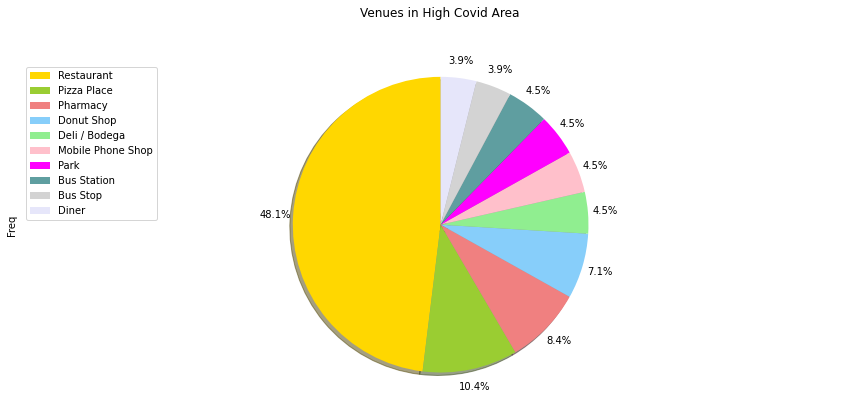

In [61]:
# draw Pie Chart for High Covid Area
drawPieChart(h_df, 'High')

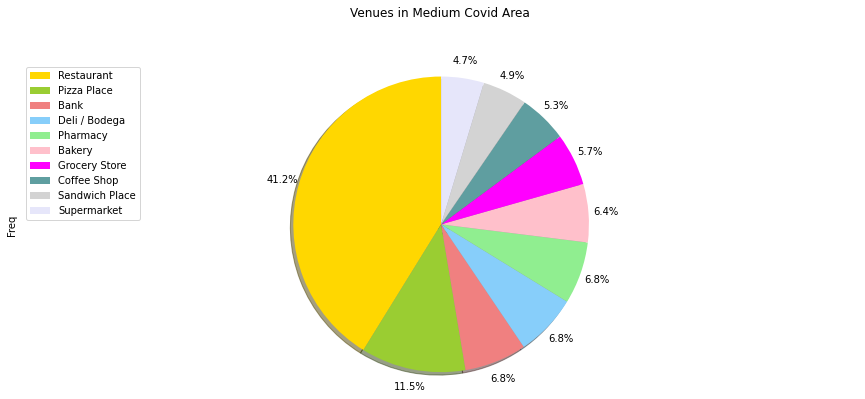

In [62]:
# draw Pie Chart for Medium Covid Area
drawPieChart(m_df, 'Medium')

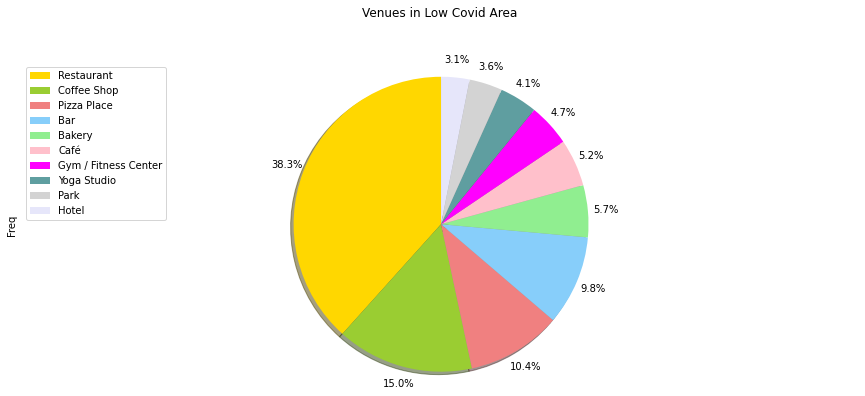

In [63]:
# draw Pie Chart for Low Covid Area
drawPieChart(l_df, 'Low')

#### Visualize Covid Cases 

In [64]:
# get the shapefile of NYC
nycMap_df = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
nycMap_df.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.252 188138.380, 1038141.936 ...  
1  POLYGON ((1001613.713 186926.440, 1002314.243 ...  
2  POLYGON ((1011174.276 183696.338, 1011373.584 ...  
3  POLYGON ((995908.365 183617.613, 996522.848 18...  
4  POLYGON ((991997.113 176307.496, 992042.798 17...

In [65]:
# merge the nycMap_df with the covid_df
nycMap_df['ZIPCODE'] = nycMap_df['ZIPCODE'].astype(int)
merged = nycMap_df.merge(covid_df, on=['ZIPCODE'], how='left')
merged = merged[['ZIPCODE', 'geometry', 'Covid-Cases']]
# show the missing data
missing_cases = merged.isnull()
for column in missing_cases.columns.values.tolist():
    print(column)
    print (missing_cases[column].value_counts())
    print("")
# simply drop whole row with NaN in "Cases" column
merged.dropna(subset=['Covid-Cases'], axis=0, inplace=True)
merged.head()

ZIPCODE
False    263
Name: ZIPCODE, dtype: int64

geometry
False    263
Name: geometry, dtype: int64

Covid-Cases
False    189
True      74
Name: Covid-Cases, dtype: int64



ZIPCODE                                           geometry  Covid-Cases
0    11436  POLYGON ((1038098.252 188138.380, 1038141.936 ...        626.0
1    11213  POLYGON ((1001613.713 186926.440, 1002314.243 ...       1824.0
2    11212  POLYGON ((1011174.276 183696.338, 1011373.584 ...       2289.0
3    11225  POLYGON ((995908.365 183617.613, 996522.848 18...       1435.0
4    11218  POLYGON ((991997.113 176307.496, 992042.798 17...       2235.0

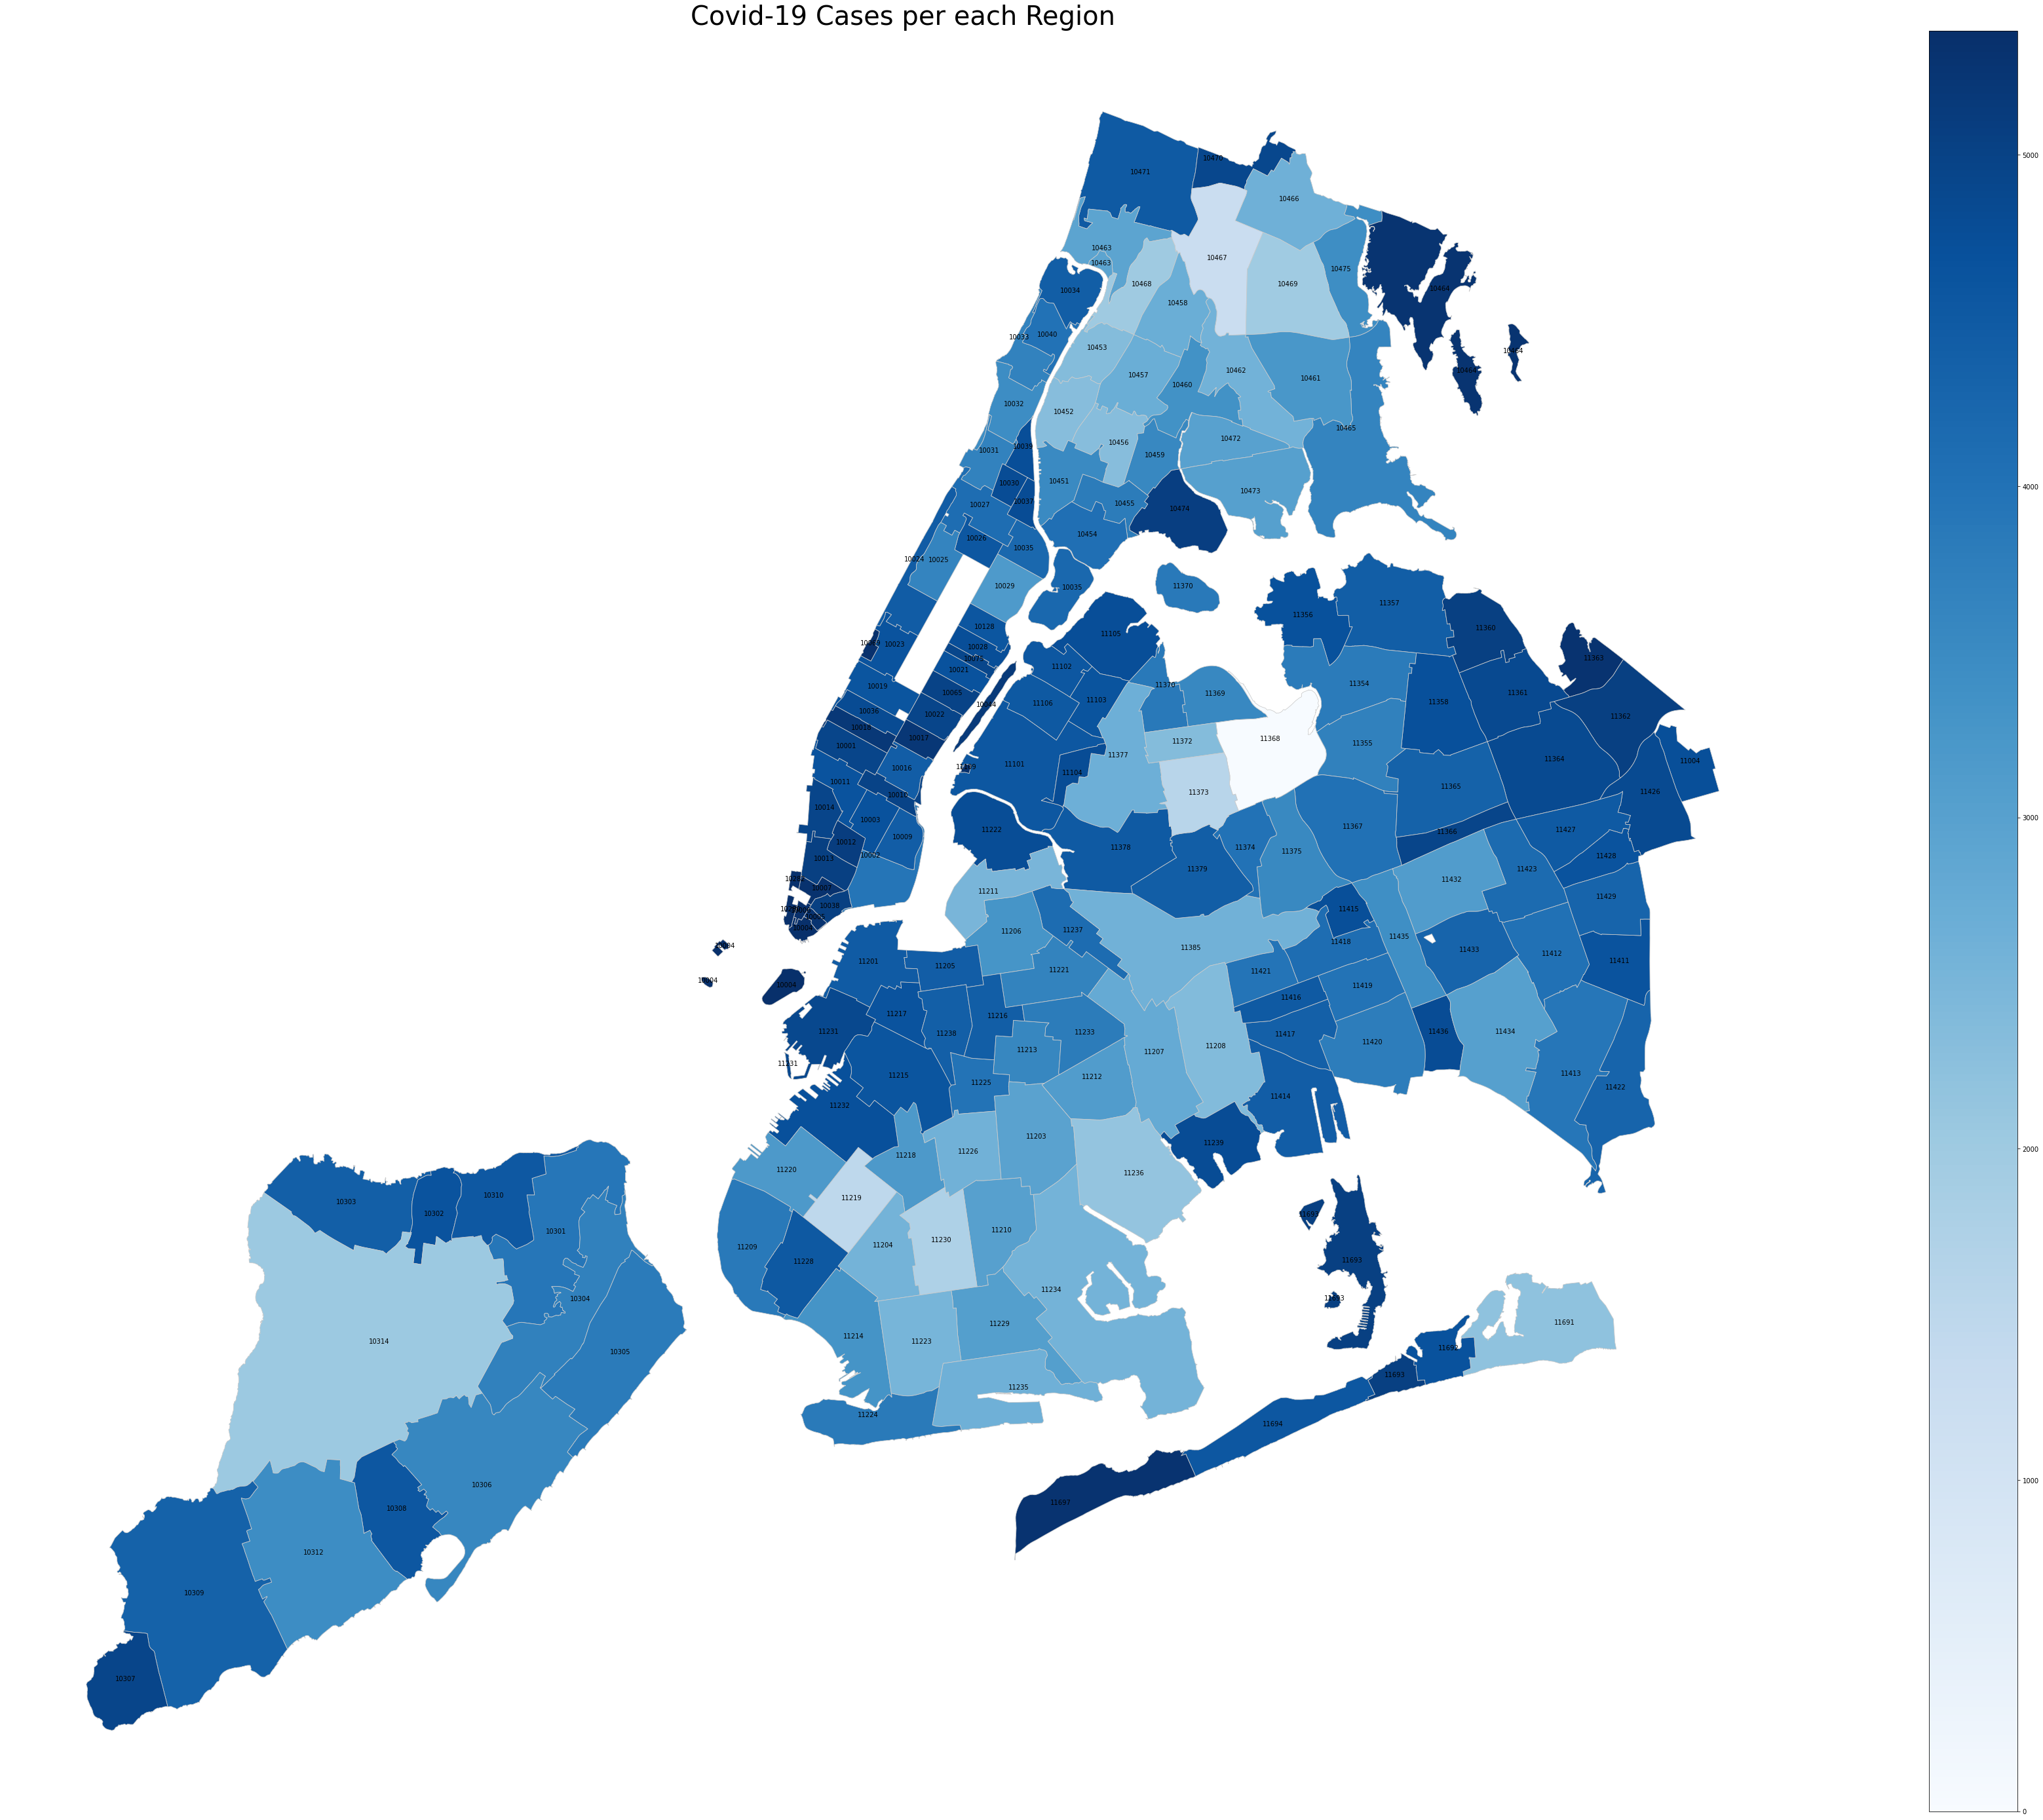

In [66]:
# set the value column that will be visualised
variable = 'Covid-Cases'
# set the range for the choropleth values
vmin, vmax = 0, int(max(merged['Covid-Cases']))
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(70, 50))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Covid-19 Cases per each Region', fontdict={'fontsize': '40', 'fontweight' : '6'})
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
merged.plot(column=variable, cmap='Blues_r', linewidth=0.8, ax=ax, edgecolor='0.8')
# Add Labels
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
for idx, row in merged.iterrows():
    plt.annotate(text=row['ZIPCODE'], xy=row['coords'],horizontalalignment='center')